# Принятие решений в бизнесе на основе данных

## Описание проекта

Аналитики крупного интернет-магазина вместе с отделом маркетинга подготовили список гипотез для увеличения выручки. Нужно приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

### Описание данных

Данные для первой части

Таблица `hypothesis` (информация о гипотезах и их параметрах): 

* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

Таблица `orders` (информация о заказах):
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Таблица `visitors` (информация о пользователях и группах А/В-теста):
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

### Задачи проекта

В первой части проекта нужно применить фреймворки RICE и ICE для приоритизации гипотез. Во второй части необходимо построить кумулятивные графики выручки, среднего чека, конверсии и их относительного изменения, точечные графики количества заказов по пользователям и стоимости заказов, посчитать для них 95-й и 99-й перцентили для определения границы аномальных заказов, а также посчитать статистическую значимость различий в конверсии и среднем чеке по «сырым» и «очищенным» данным.

В конце проекта нужно принять решение по результатам теста: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

## Шаг 1. Обзор и предобработка данных

Как обычно, перед началом работы импортируем нужные библиотеки и откроем файлы.

In [1]:
# импорт нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# чтение файлов
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Проверим данные на пригодность. Начнем с таблицы с гипотезами.

In [3]:
# первые 5 строк
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


Для удобства стоит привести названия столбцов к нижнему регистру.

In [4]:
# информация по таблице
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# проверка пропусков
hypothesis.isna().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

In [6]:
# проверка дубликатов
hypothesis.duplicated().sum()

0

В остальном с таблицей все нормально. Изменим названия столбцов.

In [7]:
# приведение к нижнему регистру
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

In [8]:
# проверка изменений
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Все хорошо, идем дальше. Посмотрим на таблицу с заказами.

In [9]:
# первые 5 строк
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Названия двух столбцов стоит изменить. Видим дату - проверим тип.

In [10]:
# информация по таблице
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Даты нужно сделать датами.

In [11]:
# проверка пропусков
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [12]:
# проверка дубликатов
orders.duplicated().sum()

0

Больше нет проблем. Поработаем с таблицей.

In [13]:
# приведение к 'змеиному_регистру'
orders = orders.rename(columns={'transactionId': 'transaction_id', 
                                'visitorId': 'visitor_id'})

In [14]:
# замена типа на дату
orders['date'] = pd.to_datetime(orders['date'])

In [15]:
# проверка изменений
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Порядок. Теперь таблица с клиентами.

In [16]:
# первые 5 строк
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Надо проверить дату на тип.

In [17]:
# информация по таблице
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Снова нужно изменить тип.

In [18]:
# проверка пропусков
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [19]:
# проверка дубликатов
visitors.duplicated().sum()

0

Сделаем замену и можно идти дальше.

In [20]:
# замена типа на дату
visitors['date'] = pd.to_datetime(visitors['date'])

In [21]:
# проверка изменений
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Полный порядок.

## Шаг 2. Приоритизация гипотез

На этом шаге стоит задача:
* применить фреймворк ICE для приоритизации гипотез и отсортировать их по убыванию приоритета;
* применить фреймворк RICE для приоритизации гипотез и отсортировать их по убыванию приоритета;
* указать, как изменилась приоритизация гипотез при применении RICE вместо ICE, и объяснить, почему так произошло.

Вспомним что ICE считается так: Impact * Confidence / Efforts. Применим формулу к данным.

In [22]:
# создание столбца с фреймворком ICE
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
# вывод
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


В приоритете гипотезы с номерами 8, 0, 7, 6 и 2. Применяем следующий фреймворк.

RICE считается так: Reach * Impact * Confidence / Efforts. Считаем.

In [23]:
# создание столбца с фреймворком RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)
# вывод
pd.options.display.max_colwidth = 300
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


В приоритете гипотезы с номерами 7, 2, 0, 6 и 8. Номера те же, но порядок другой. Это произошло потому, что вторая формула учитывает охват пользователей. Параметр Reach выше у гипотез 7 и 2, поэтому они в первых рядах.

## Шаг 3. Анализ A/B-теста

<div class="alert alert-danger">
    
  <b>Комментарий ревьюера</b>

  ❌ Еще остается не выполненным на этапе предобработки, но тем не менее важным - проверить корректность разбиения пользователей на группы - может быть есть пользователи, попавшие в обе группы? Если таковые пользователи есть, нужно их выявить и выработать стратегию работы с такими данными. Пересечение групп сильно влияет на результаты теста, если процент достаточно большой. Если есть возможность их можно удалить и посмотреть, какие результаты получаются без них, в любом случае к результатам теста придется относится осторожно.
</div>

In [24]:
# проверка корректности разбиения пользователей по группам
visitors['group'].unique()

array(['A', 'B'], dtype=object)

Пользователи принадлежат либо к группе А, либо к группе В. Здесь с данными все в порядке.

In [25]:
# альтернативная проверка корректности разбиения пользователей по группам
visitors.groupby(['group']).count()

,date,visitors
group,,
A,31,31
B,31,31


И здесь тоже две группы.

<div class="alert alert-block alert-info">
  
  <b>Комментарий cтудента</b>
    
  Готово.
</div>
<div class="alert alert-danger">
    
  <b>Комментарий ревьюера v.2</b>

  ❌ Ты просто проверила, что у нас всего 2 группы. Надо проверить на наличие пользователей, попавших одновременно в обе группы.
</div>

In [26]:
# проверка корректности разбиения пользователей по группам
count_groups = orders.groupby(['visitor_id'])['group'].nunique().reset_index()
count_groups.query('group > 1').count()

visitor_id    58
group         58
dtype: int64

Есть пользователи, попавшие в обе группы. Удаляем.

In [27]:
# определение количества групп
count_groups.columns = ['visitor_id', 'group_new']
count_groups

,visitor_id,group_new
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


In [28]:
# объединение таблицы с заказами и таблицы с количеством групп
orders = orders.merge(count_groups, how = 'left', on = 'visitor_id')
orders

,transaction_id,visitor_id,date,revenue,group,group_new
0,3667963787,3312258926,2019-08-15,1650,B,1
1,2804400009,3642806036,2019-08-15,730,B,1
2,2961555356,4069496402,2019-08-15,400,A,2
3,3797467345,1196621759,2019-08-15,9759,B,1
4,2282983706,2322279887,2019-08-15,2308,B,1
...,...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B,1
1193,2203539145,370388673,2019-08-14,3190,A,1
1194,1807773912,573423106,2019-08-14,10550,A,1
1195,1947021204,1614305549,2019-08-14,100,A,2


In [29]:
# обрезка пользователей в обеих группах
orders = orders.query('group_new != 2')
orders

,transaction_id,visitor_id,date,revenue,group,group_new
0,3667963787,3312258926,2019-08-15,1650,B,1
1,2804400009,3642806036,2019-08-15,730,B,1
3,3797467345,1196621759,2019-08-15,9759,B,1
4,2282983706,2322279887,2019-08-15,2308,B,1
5,182168103,935554773,2019-08-15,2210,B,1
...,...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B,1
1192,2662137336,3733762160,2019-08-14,6490,B,1
1193,2203539145,370388673,2019-08-14,3190,A,1
1194,1807773912,573423106,2019-08-14,10550,A,1


<div class="alert alert-danger">
    
  <b>Комментарий ревьюера v.3</b>
    
  ❌ Нам надо удалить пользователей, а не группы эксперемента. 
    
Чтобы найти пользователей, достаточно просто сгруппировать orders по пользователю `visitorId` и выбрать уникальные группы для них `['group'].nunique().reset_index()`, а дальше просто обрезать тех, у кого больше чем одна группа `query('group > 1')`.
</div>

<div class="alert alert-block alert-info">
  
  <b>Комментарий cтудента</b>
    
  Исправлено.
</div>
<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.4</b>
    
  ✔️ Хорошо, результаты теста они больше не искажают. 
</div>

Прежде чем приступить к анализу А/В теста, необходимо создать датафрейм (назовем его `dates_groups`) с уникальными парами значений `date` и `group` таблицы `orders`, а затем избавиться от дубликатов методом `drop_duplicates()`.

In [30]:
# массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

Теперь нужно получить агрегированные кумулятивные по дням данные о заказах и посетителях интернет-магазина. Создадим переменные. 

`orders_aggregated` будет содержать:
* дату;
* группу A/B-теста;
* число уникальных заказов в группе теста по указанную дату включительно;
* число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
* суммарную выручку заказов в группе теста по указанную дату включительно.

`visitors_aggregated` будет содержать:
* дату;
* группу A/B-теста;
* количество уникальных посетителей в группе теста по указанную дату включительно.

Две таблицы будут объединены в одну.

In [31]:
# агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# aгрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединение кумулятивных данных в одной таблице
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

# присваивание понятных названий
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors']

# первые 5 строк
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Объявим переменные, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.

In [32]:
# кумулятивное количество заказов и кумулятивная выручка по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# кумулятивное количество заказов и кумулятивная выручка по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

Посмотрим на график кумулятивной выручки по группам.

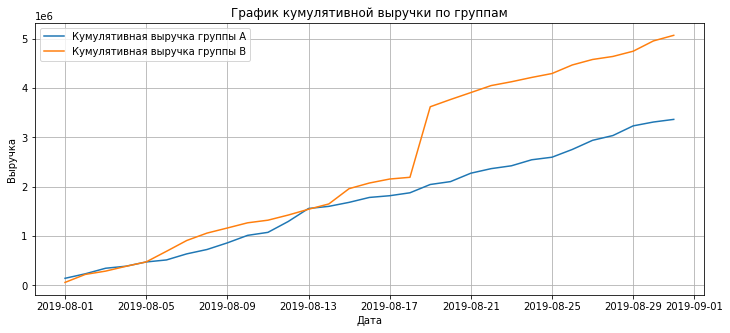

In [33]:
# график кумулятивной выручки по группам
plt.figure(figsize=(12,5))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='Кумулятивная выручка группы A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='Кумулятивная выручка группы B')
plt.grid()
plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend()
plt.show()

Выручка группы А растет линейно и плавно, а в группе В, видимо, есть выбросы, т.к. наблюдается резкий скачок. Выручка сравнялась 13-го числа, а затем в группе В либо стало больше заказов, либо сами заказы были дороже (проверим это). В целом, группа В лидирует по размеру выручки, её линия на графике выше линии группы А.

Посмотрим, что происходило с заказами 19-го числа (день с резким скачком) в группе В.

In [34]:
# срез данных в дни около скачка
cumulative_revenue_B.query('"2019-08-17" <= date <= "2019-08-21"')

,date,revenue,orders
33,2019-08-17,2155542,320
35,2019-08-18,2190865,327
37,2019-08-19,3620785,348
39,2019-08-20,3768059,368
41,2019-08-21,3908406,380


Количество заказов растет довольно плавно, а вот выручка увеличилась почти в два раза и осталась примерно на том же уровне с постепенным ростом. Посмотрим, что так повлияло на неё.

In [35]:
# срез данных в нужный день
orders.query('date == "2019-08-19"').sort_values(by='revenue', ascending=False).head()

,transaction_id,visitor_id,date,revenue,group,group_new
425,590470918,1920142716,2019-08-19,1294500,B,1
530,3970235543,2912540959,2019-08-19,43990,A,1
527,1570513684,2837914161,2019-08-19,33405,B,1
421,3765974140,1357170471,2019-08-19,31680,A,1
461,2683113224,154576532,2019-08-19,26550,B,1


Есть один большой заказ. Можно считать его выбросом, поскольку ближайший заказ в 29 раз меньше.

Следующая задача - построить график кумулятивного среднего чека по группам. Для этого  разделим кумулятивную выручку на кумулятивное число заказов.

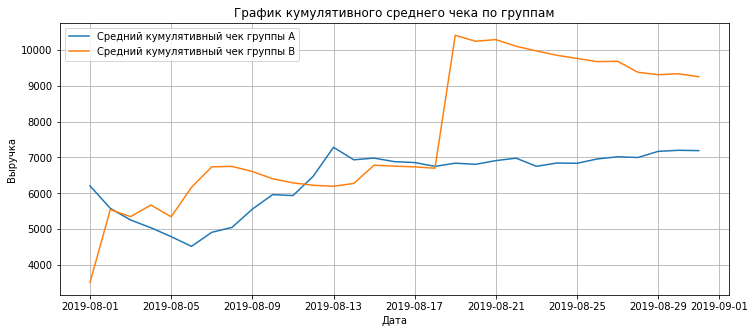

In [36]:
# график кумулятивного среднего чека по группам
plt.figure(figsize=(12,5))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='Средний кумулятивный чек группы A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='Средний кумулятивный чек группы B')
plt.grid()
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.legend()
plt.show()

Здесь также виден резкий скачок в группе В - это тот большой заказ с номером 425. После него выручка даже стала снижаться. В группе А средний чек пару раз превышал сумму группы В, но в целом чек группы В намного больше.

Построим теперь график относительного изменения кумулятивного среднего чека группы B к группе A. Для этого нужно собрать данные о выручке в одном датафрейме.

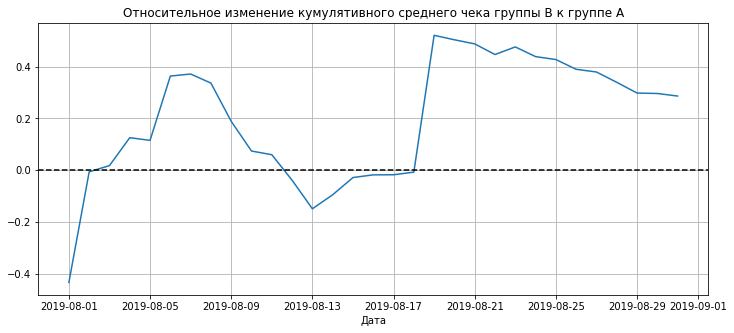

In [37]:
# объединение данных в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, 
                                                       left_on='date', 
                                                       right_on='date', 
                                                       how='left', 
                                                       suffixes=['A', 'B'])

# график отношения средних чеков
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']
                                             /merged_cumulative_revenue['ordersB'])
                                             /(merged_cumulative_revenue['revenueA']
                                             /merged_cumulative_revenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе А')
plt.xlabel('Дата')
plt.show()

Здесь выводы будут похожими на предыдущий пункт. В целом, средний чек группы В намного больше, чем в группе А. Снижение наблюдается только в дни, когда средний чек группы В был ниже, как на прошлом графике. Так же виден резкий скачок 19-го числа за счет аномально большого заказа, в последующие дни средний чек постепенно снижается.

Построим график кумулятивной конверсии по группам. Для этого нужно посчитать конверсию.

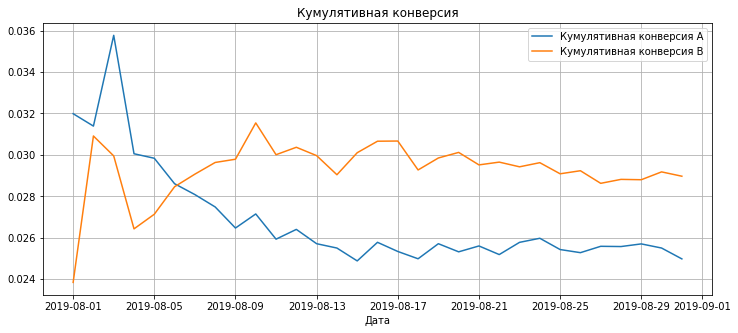

In [38]:
# кумулятивная конверсия
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# разделение данных по группам
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# графики с конверсией
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='Кумулятивная конверсия A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='Кумулятивная конверсия B')
plt.legend()
plt.title('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.show()

В начале месяца у обоих групп был пик конверсии, затем 6-го числа произошел переломный момент - конверсия группы В ушла вверх и осталась лидером, хотя и с постепенным снижением, конверсия группы А так и не стала повышаться. Вероятно, группе В предлагали хорошую скидку или выгодную акцию.

Посмотрим на график относительного изменения кумулятивной конверсии группы B к группе A. Для этого нужно объединить данные по группам.

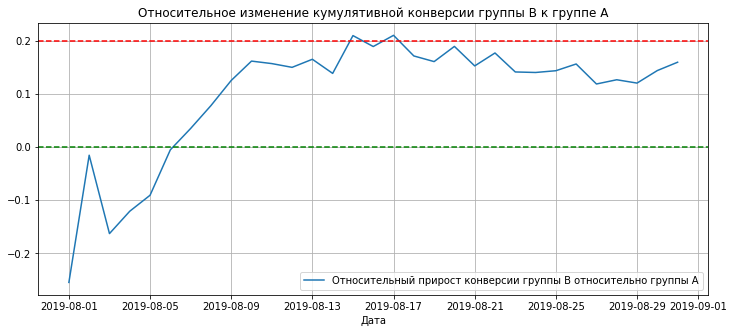

In [39]:
# объединение данных по группам
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].merge(cumulative_data_B[['date','conversion']], 
                                                                             left_on='date', 
                                                                             right_on='date', 
                                                                             how='left', 
                                                                             suffixes=['A', 'B'])
# график относительного изменения конверсии
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']
                                                /merged_cumulative_conversions['conversionA']-1, 
                                                label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='green', linestyle='--')
plt.axhline(y=0.2, color='red', linestyle='--')
plt.legend()
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.show()

Конверсия группы В выглядит лучше. Достигнув показателя около 21% в середине рассматриваемого периода, она стала понемногу снижаться и осталась на уровне 12-14% относительно группы А. График снижался в дни, когда конверсия группы А была выше (возможно, проводилась акция или были скидки).

Посмотрим, как обстоит дело с количеством заказов. Построим точечный график количества заказов по пользователям. Для этого нужно создать отдельный датафрейм.

In [40]:
# количество заказов по пользователям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
# удобные названия столбцов
orders_by_users.columns = ['visitors', 'orders']
# вывод с сортировкой
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,visitors,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Визуализируем.

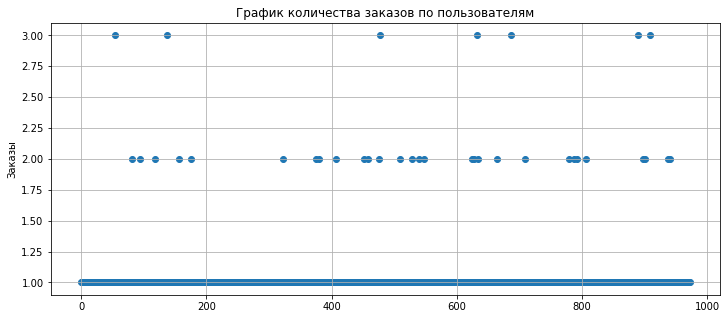

In [41]:
# график количества заказов по пользователям
x_values = pd.Series(range(0,len(orders_by_users)))
plt.figure(figsize=(12,5))
plt.grid()
plt.title('График количества заказов по пользователям')
plt.ylabel('Заказы')
plt.scatter(x_values, orders_by_users['orders'])
plt.show()

Абсолютное большинство пользователей совершили 1 заказ. Тех, кто заказывал дважды, уже меньше. Еще меньше людей с тремя заказами. Непонятно пока, какое количество заказов считать аномалией, но больше 4-х заказов точно.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя, чтобы выбрать границу для определения аномальных пользователей.

In [42]:
# расчет 95-го и 99-го перцентилей количества заказов
np.percentile(orders_by_users['orders'], [95, 99])

array([1., 2.])

Теперь понятно, что не более 5% пользователей сделали больше 1-го заказа и не более 1% сделали больше 2-х заказов. Будем считать аномалией 2 заказа и более.

Построим точечный график стоимостей заказов.

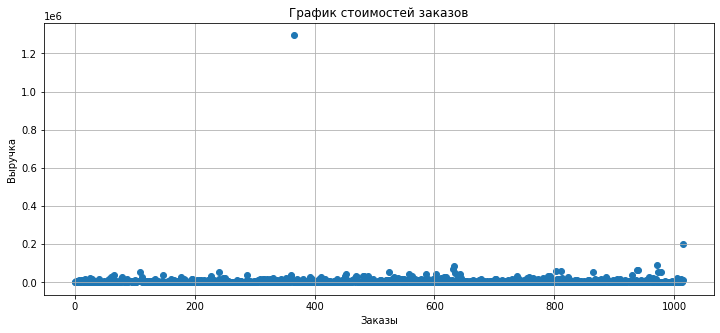

In [43]:
# график стоимостей заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12,5))
plt.grid()
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов')
plt.ylabel('Выручка')
plt.xlabel('Заказы')
plt.show()

Ничего не понятно. Зато видно тот самый дорогой заказ с номером 425. Уберем слишком дорогие заказы.

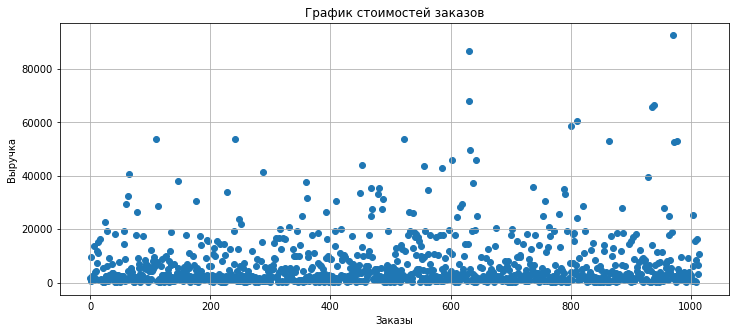

In [44]:
# фильтрация высоких значений
new_orders = orders[orders['revenue']<=195000]['revenue']
xn_values = pd.Series(range(0,len(new_orders)))
plt.figure(figsize=(12,5))
plt.grid()
plt.scatter(xn_values, new_orders)
plt.title('График стоимостей заказов')
plt.ylabel('Выручка')
plt.xlabel('Заказы')
plt.show()

Выбросы находятся на уровне примерно 20 000 и выше. Чтобы быть уверенными, рассчитаем 95-й и 99-й перцентили стоимости заказов.

In [45]:
# расчет 95-го и 99-го перцентилей стоимости заказов
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Теперь понятно, что выбросами можно считать заказы стоимостью более 53 904 (не более 1% заказов).

Остается посчитать статистическую значимость для различий в конверсии и среднем чеке для групп. Для этого нужно собрать все данные по заказам и визитам и добавить кумулятивные показатели, а потом объединить все в одну таблицу.

In [46]:
# данные по визитам и кумулятивные показатели

visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}), axis=1)

visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']


visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}), axis=1)

visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

# данные по заказам и кумулятивные показатели

orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))

orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}), axis=1,
).sort_values(by=['date'])

orders_A_cummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A']


orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))

orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}), axis=1,
).sort_values(by=['date'])

orders_B_cummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B']

# объединение данных

data = (
    orders_A_daily.merge(
    orders_B_daily, left_on='date', right_on='date', how='left')
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left'))

Создадим переменные `orders_by_users_A` и `orders_by_users_B` со столбцами `user_id` и `orders`, где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов. Объявим переменные `sample_A` и `sample_B`, в которых пользователям с заказами будет соответствовать число заказов пользователя, а пользователям без заказов - нули.

In [47]:
# подготовка данных к проверке статистической значимости

orders_by_users_A = orders[orders['group']=='A'].groupby('visitor_id', 
                                                         as_index=False).agg({'transaction_id' : pd.Series.nunique})
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = orders[orders['group']=='B'].groupby('visitor_id', 
                                                         as_index=False).agg({'transaction_id' : pd.Series.nunique})
orders_by_users_B.columns = ['user_id', 'orders']

sample_A = pd.concat([orders_by_users_A['orders'], pd.Series(
    0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['orders'], pd.Series(
    0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])), name='orders')],axis=0)

Готово. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

Формулируем гипотезы:
* H0: Конверсия в группе A равна конверсии в группе B
* H1: Конверсия в группе A не равна конверсии в группе B

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Нулевая и альтернативная гипотезы сформулированы.
</div>

In [48]:
# проверка статистической значимости различий в конверсии по «сырым» данным
print('alpha =',0.05)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sample_A, sample_B)[1]))
print('Относительный прирост конверсии группы В к группе А = {0:.3f}'.format(
    (data['orders_per_date_B'].sum()
     /data['visitors_per_date_B'].sum())
     /(data['orders_per_date_A'].sum()
     /data['visitors_per_date_A'].sum())-1))

alpha = 0.05
p-value = 0.011
Относительный прирост конверсии группы В к группе А = 0.160


Итак, p-value меньше 0.05. Это значит, что мы отвергаем нулевую гипотезу о равенстве конверсий между группами. По «сырым» данным конверсия группы В превышает конверсию группы А на 13,8%.

Посчитаем теперь статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Формулируем гипотезы:
* H0: Средний чек в группе A равен среднему чеку в группе B
* H1: Средний чек в группе A не равен среднему чеку в группе B

In [49]:
# проверка статистической значимости различий в среднем чеке по «сырым» данным
print("alpha =",0.05)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                    orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы В к группе А = {0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

alpha = 0.05
p-value = 0.829
Относительный прирост среднего чека группы В к группе А = 0.287


Итак, р-value больше 0.05. Это значит, что нет причин отвергать нулевую гипотезу о равенстве среднего чека между группами. По «сырым» данным средний чек примерно равен в группах. Хотя разница между ними составляет почти 26%, ее нельзя считать статистически значимой.

Теперь нужно «очистить» данные и снова посчитать статистическую значимость.

Вспомним, какие значения мы считаем аномальными. Для количества заказов это 4 и более (не более 1% пользователей), для стоимости заказов это 58 233 и более (не более 1% заказов).

In [50]:
# очистка данных

users_with_many_orders = pd.concat([
        orders_by_users_A[orders_by_users_A['orders'] > 1]['user_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 1]['user_id']], axis=0)

revenue_lim = 53904
users_with_expensive_orders = orders[orders['revenue'] > revenue_lim]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values())

sample_A_filtered = pd.concat([
    orders_by_users_A[np.logical_not(orders_by_users_A['user_id'].isin(abnormal_users))]['orders'], \
                             pd.Series(
        0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), \
        name='orders')],axis=0)

sample_B_filtered = pd.concat([
    orders_by_users_B[np.logical_not(orders_by_users_B['user_id'].isin(abnormal_users))]['orders'], \
                             pd.Series(
        0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])), \
        name='orders')],axis=0)

Готово.

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Формулируем гипотезы:
* H0: Конверсия в группе A равна конверсии в группе B
* H1: Конверсия в группе A не равна конверсии в группе B

In [51]:
# проверка статистической значимости различий в конверсии по «очищенным» данным
print('alpha =',0.05)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('Относительный прирост конверсии группы В к группе А = {0:.3f}'.format(
    sample_B_filtered.mean()/sample_A_filtered.mean()-1))

alpha = 0.05
p-value = 0.008
Относительный прирост конверсии группы В к группе А = 0.188


Здесь p-value так же меньше 0.05. Различия между конверсиями есть, т.к. мы отвергаем нулевую гипотезу. По «сырым» данным конверсия группы В превышала конверсию группы А на 13,8%, а по «очищенным» - на 20,5%.

Наконец, посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Формулируем гипотезы:
* H0: Средний чек в группе A равен среднему чеку в группе B
* H1: Средний чек в группе A не равен среднему чеку в группе B

In [52]:
# проверка статистической значимости различий в среднем чеке по «очищенным» данным
print("alpha =",0.05)

print('p-value = {0:.3f}'.format(stats.mannwhitneyu(
        orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1]))

print('Относительный прирост среднего чека группы В к группе А = {0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1)) 

alpha = 0.05
p-value = 0.969
Относительный прирост среднего чека группы В к группе А = 0.002


Получается, р-value и здесь больше 0.05. Это значит, что нет причин отвергать нулевую гипотезу о равенстве среднего чека между группами. По «сырым» данным средний чек был примерно равен в группах, и разница между ними составляла почти 26% (статистической значимости для нее нет). По «очищенным» данным чек также равен, но разница уже минимальна - всего 0,2%. Такую большую разницу дал по большей мере тот самый заказ с номером 425. 

## Общий вывод

По результатам тестирования было выявлено:

Статистически значимые различия между конверсиями групп есть. По «сырым» данным конверсия группы В превышала конверсию группы А на 13,8%, а по «очищенным» - на 20,5%.

Нет статистически значимых различий между средними чеками групп и по «сырым», и по «очищенным» данным, хотя была заметна разница между ними в «сырых» данных на почти 26% - здесь сказалось влияние большого аномального заказа. Статистической значимости для такой большой разницы не было.

Тестирование можно останавливать и объявлять победу группы В по показателям конверсии, группы можно считать равными по показателям среднего чека.